# **Trabalho Final de PPC - Criação do algoritmo de prova de trabalho paralelo**

##**Definindo um bloco de transações:**

In [0]:
bloco = {
    "tansacoes": [
                    "marcio->tarik:1000BTC", 
                    "tarik->breno:500BTC",
                    "felipe->marcio:10BTC",
                    "marcio->tarik:10BTC",
                    "marcio->marcio:0.5BTC",
                 ],
    "id": 1789,
    "nounce": 0
}

##**Gerando o hash SHA256 do bloco**

In [43]:
import hashlib
bloco_str = str(bloco)
bloco_hash = hashlib.sha256(bloco_str.encode()).hexdigest()
print(f"Hash do bloco {bloco['id']}: {bloco_hash}")

Hash do bloco 1789: 2b32b85ea32288286612363e52cbfc403617d6de6a833fae61ec911569373734


##**Implementação serial do algoritmo Hashcash**
Minerando o bloco definido anteriormente 

Definindo a funçao serial que executará o algoritmo POW

In [0]:
def serial_POW(bloco, bloco_hash):
  while bloco_hash[0:6] != '000000':
      bloco['nounce'] += 1
      bloco_str = str(bloco)
      bloco_hash = hashlib.sha256(bloco_str.encode()).hexdigest()
  print(f"Bloco minerado!\nNovo hash: {bloco_hash}")
  print(f"Prova de trabalho: {bloco['nounce']}") 

In [0]:
from mpi4py import MPI #A impotação está sendo feita aqui para permitir o uso da Wtime

In [46]:
tempo_ini = MPI.Wtime()
serial_POW(bloco, bloco_hash)
tempo_fin = MPI.Wtime()
tempo_exec_serial = tempo_fin - tempo_ini
print("Tempo de execução serial:", tempo_exec_serial)

Bloco minerado!
Novo hash: 000000c0f346a17e4f552f08e083ef86c95ff3403ab03935ba084b65effd05da
Prova de trabalho: 42559205
Tempo de execução serial: 156.42269055999986


# Implementação paralela do algoritmo Hashcash

A idéia é assumir que os hashs são gerados de maneira aleatória e, portanto, cada um de seus dígitos também é, baseado nisso, pode-se estimar um número de tentativas T suficientes de diferentes valores de nounces que devem ser testados para gerar um hash com os N primeiros dígitos hexadecimais iguais a zero:

* Probabilidade de se gerar um hash com os N dígitos hexadecimais iniciais iguais a zero:

\begin{equation*}
    p = \left( \frac{1}{16} \right)^N
\end{equation*}
    
* Estimativa da quantidade de tentativas necessárias para gerar um hash com os N primeiros dígitos hexadecimais nulos:

\begin{equation*}
    T = \frac{1}{p} = \frac{1}{\left(\frac{1}{16}\right)^N}
\end{equation*}
    
Após a definição de T, cada processo testará uma uma faixa de T/P valores de nounces, onde P é a quantidade de processos em execução. Quando um processo encontrar o nounce que gera o hash adequado, ou seja, a Prova de Trabalho(POW), ele envia uma mensagem a todos os outros processos, que encerram sua execução. Se nenhum processo encontrar a Prova de Trabalho, os próximos T valores de nounces são testados e assim sucessivamente, até que a Prova de Trabalho seja encontrada.

## Definindo o número de dígitos iniciais nulos e calculando a quantidade de tentativas necessárias de nounces para encontrar o hash adequado

In [0]:
import math

In [0]:
N = 6

In [0]:
T = math.ceil(1/(1/16)**N)*4 #O *4 é apenas para testes

In [50]:
print("Número de tentativas estimado:", T)

Número de tentativas estimado: 67108864


## Executando a versão paralela do algoritmo

In [0]:
exec = !mpirun --allow-run-as-root -n 8 python3 parallel_pow.py {N} {T}

In [57]:
exec

['Sou o processo 0 e vou testar de 0 até 8388608',
 'Hash inicial 2b32b85ea32288286612363e52cbfc403617d6de6a833fae61ec911569373734',
 'Sou o processo 2 e vou testar de 16777216 até 25165824',
 'Sou o processo 1 e vou testar de 8388608 até 16777216',
 'Sou o processo 3 e vou testar de 25165824 até 33554432',
 'Sou o processo 5 e vou testar de 41943040 até 50331648',
 'Sou o processo 6 e vou testar de 50331648 até 58720256',
 'Sou o processo 7 e vou testar de 58720256 até 67108864',
 'Sou o processo 4 e vou testar de 33554432 até 41943040',
 'O processo 5 encontrou a prova de trabalho',
 'Prova de trabalho 42559205',
 'Tempo de execução: 26.66942347999975']

In [0]:
tempo_exec_paralela = float(exec[-1].split(':')[1])

In [59]:
tempo_exec_paralela

26.66942347999975

## Cálculo do speedup

In [60]:
speedup = tempo_exec_serial/tempo_exec_paralela
print("Speedup:", speedup)

Speedup: 5.86524454408646


In [0]:
from google.colab import files
from IPython.display import Image

In [0]:
uploaded = files.upload()

Saving photo_2019-07-03_23-31-07.jpg to photo_2019-07-03_23-31-07.jpg


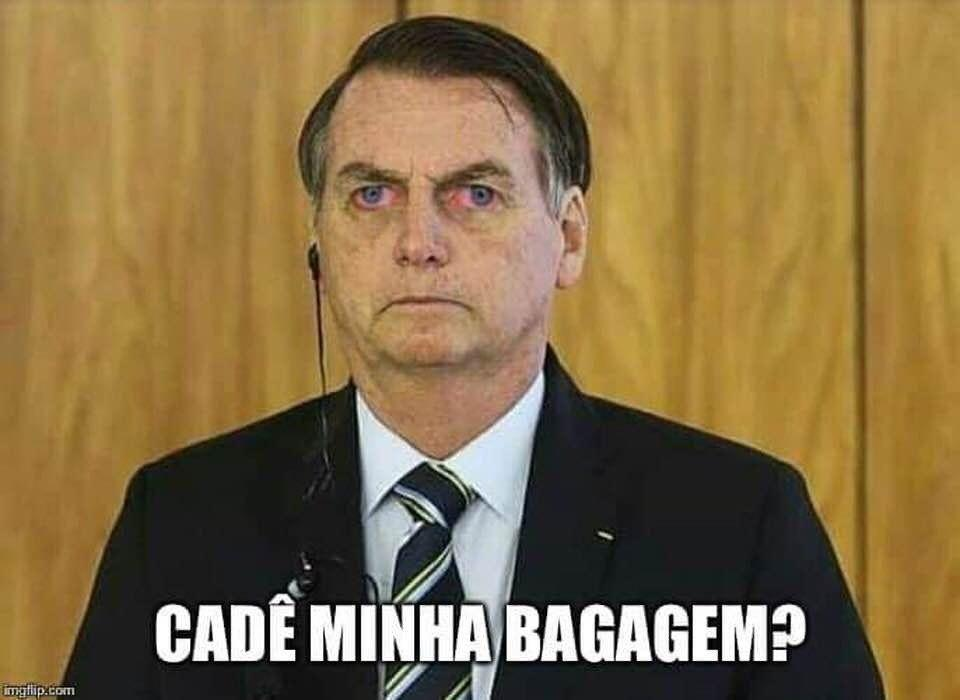

In [0]:
Image("photo_2019-07-03_23-31-07.jpg")